## Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_datasets as tfds

# Set random seed
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

# Load dataset

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Patch_Camelyon_tfds/'

data, info = tfds.load("patch_camelyon", with_info=True, data_dir=root_path, shuffle_files=True)

train_ds = data['train']
valid_ds = data['validation']
test_ds = data['test']

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Need to split each instance of the dataset in image and label
def split_data(data):
  return data["image"], data["label"]

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(split_data, num_parallel_calls=AUTOTUNE).shuffle(1024).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.map(split_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(split_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Small portion of the dataset used during the inital tests
# small_train_ds = train_ds.map(split_data, num_parallel_calls=AUTOTUNE).take(1024).cache().shuffle(1024).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# small_valid_ds = valid_ds.map(split_data, num_parallel_calls=AUTOTUNE).take(1024).batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

### Visualize dataset items

In [ ]:
# !pip install --upgrade tensorflow-datasets
# fig = tfds.show_examples(train_ds, info)

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018

In [ ]:
# Show 16 examples of images with their labels
i = 0
plt.figure(figsize=(15,15))
for data in train_ds.take(16):
  img = data["image"]
  label = data["label"]
  i += 1
  plt.subplot(4,4,i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title(label.numpy())
plt.show()

# Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomZoom((-0.125,0), fill_mode='reflect'),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation((-0.5,0.5)),
  layers.experimental.preprocessing.RandomContrast(0.4)
], name="data_augmentation")

def random_brightness_layer(factor=0.4):
  return layers.Lambda(lambda x: tf.image.random_brightness(x, factor))

def random_hue_layer(factor=0.2):
  return layers.Lambda(lambda x: tf.image.random_hue(x, factor))

def random_saturation_layer(lower=0.8, upper=1.2):
  return layers.Lambda(lambda x: tf.image.random_saturation(x, lower, upper))

random_brightness_layer = random_brightness_layer()
random_hue_layer = random_hue_layer()
random_saturation_layer = random_saturation_layer()

<dtype: 'float32'>
<dtype: 'float32'>


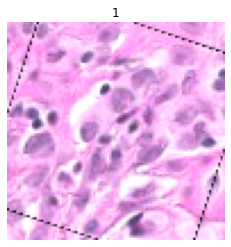

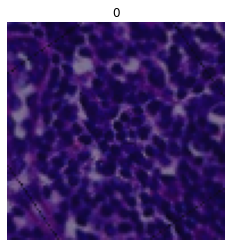

In [ ]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(int(label.numpy()))
  plt.axis('off')

# Show examples of images after applying data augmentation
for image, label in train_ds.take(2):
  image = layers.experimental.preprocessing.Rescaling(1./255)(image)
  image = random_brightness_layer(image)
  image = random_hue_layer(image)
  image = random_saturation_layer(image)
  image = data_augmentation(image)
  show(image[0], label[0])
  print(image[0].dtype)

# Create model

### Model 1

In [ ]:
model = tf.keras.Sequential([
  tf.keras.Input((96, 96, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  data_augmentation,
  random_brightness_layer,
  random_hue_layer,
  random_saturation_layer,

  layers.Conv2D(16, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
  layers.Conv2D(16, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
  layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

  layers.Conv2D(32, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
  layers.Conv2D(32, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
  layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

  layers.Conv2D(64, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
  layers.Conv2D(64, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
  layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

  layers.Flatten(),
  layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
  layers.Dropout(0.5),
  layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
  layers.Dropout(0.5),
  layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
data_augmentation (Sequentia (None, 96, 96, 3)         0         
_________________________________________________________________
lambda (Lambda)              (None, 96, 96, 3)         0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 96, 96, 3)         0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 16)        2

# Fit model

In [ ]:
# Set name of the path where to save the model
folder = os.path.join(root_path,'models_NN',"PCam_NN_Final2")
savename = "PCam_NN_Final2_lr0_0005_L20_0001_30epochs.h5"

In [ ]:
# Call to decrease the learning rate of the optimizer
# model.optimizer.lr.assign(model.optimizer.lr * 0.1)

In [ ]:
epochs=30
callbacks = [ModelCheckpoint(os.path.join(folder,savename), save_best_only=True, verbose=1)]

history = model.fit(
  train_ds,
  validation_data = valid_ds,
  epochs = epochs,
  callbacks = callbacks
)

# Load Model (best epoch)

In [ ]:
model = models.load_model(os.path.join(folder,savename))

In [ ]:
os.path.join(folder,savename)

'/content/gdrive/My Drive/Patch_Camelyon_tfds/models_NN/PCam_NN_Final2/PCam_NN_Final2_lr0_0005_L20_0001_30epochs.h5'

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_14 (Rescaling)     (None, 96, 96, 3)         0         
_________________________________________________________________
data_augmentation (Sequentia (None, 96, 96, 3)         0         
_________________________________________________________________
lambda_9 (Lambda)            (None, 96, 96, 3)         0         
_________________________________________________________________
lambda_10 (Lambda)           (None, 96, 96, 3)         0         
_________________________________________________________________
lambda_11 (Lambda)           (None, 96, 96, 3)         0         
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 94, 94, 16)        448       
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 92, 92, 16)      

# Test

In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds)

1024/1024 [==============================] - 21s 21ms/step - loss: 0.3867 - accuracy: 0.8437


# Graphs

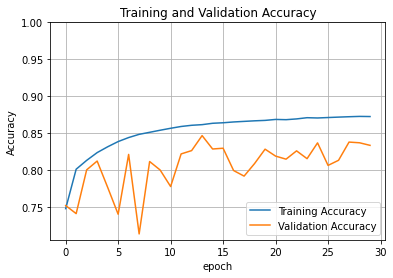

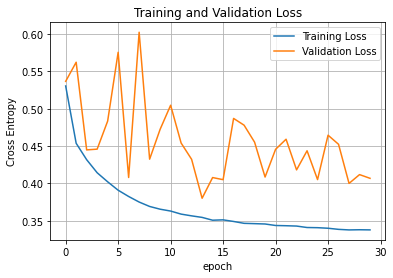

In [ ]:
#Evaluate and plot the graphs of accuracy and loss.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.grid()
plt.savefig(os.path.join(folder,"accuracy.png"))

plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(os.path.join(folder,"loss.png"))
plt.grid()
plt.show()

# Save some info about the best model
f = open(os.path.join(folder,"info.txt"), "w")
best_epoch = np.argmin(val_loss)
f.writelines("Best epoch: " + str(best_epoch + 1) + "\n")
f.write("Training accuracy: " + str(acc[best_epoch]) + "\n")
f.write("Validation accuracy: " + str(val_acc[best_epoch]) + "\n")
f.write("Training loss: " + str(loss[best_epoch]) + "\n")
f.write("Validation loss: " + str(val_loss[best_epoch]) + "\n\n")
f.write("Test accuracy: " + str(test_accuracy) + "\n")
f.write("Test loss: " + str(test_loss) + "\n")
f.close()

# Hyperparameters Tuning

In [ ]:
import IPython
!pip install -q -U keras-tuner
import kerastuner as kt

In [ ]:
# Define hypermodel
def model_builder(hp):
  hp_l2_regularizer = hp.Choice('l2_regularizer', values = [1e-2, 1e-3, 1e-4]) 
  hp_units = hp.Choice('units', values = [32, 64, 128, 256, 512])
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]) 

  model = tf.keras.Sequential([
    tf.keras.Input((96, 96, 3)),
    layers.experimental.preprocessing.Rescaling(1./255),
    data_augmentation,
    random_brightness_layer,
    random_hue_layer,
    random_saturation_layer,

    layers.Conv2D(16, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(hp_l2_regularizer)),
    layers.Conv2D(16, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(hp_l2_regularizer)),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(32, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(hp_l2_regularizer)),
    layers.Conv2D(32, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(hp_l2_regularizer)),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Conv2D(64, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(hp_l2_regularizer)),
    layers.Conv2D(64, 3, padding='valid', activation='relu', kernel_regularizer=keras.regularizers.l2(hp_l2_regularizer)),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),

    layers.Flatten(),
    layers.Dense(hp_units, activation='relu', kernel_regularizer=keras.regularizers.l2(hp_l2_regularizer)),
    layers.Dropout(0.5),
    layers.Dense(hp_units, activation='relu', kernel_regularizer=keras.regularizers.l2(hp_l2_regularizer)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [ ]:
# Search for the best hyperparameters using hyperband
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10)   

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

tuner.search(train_ds, epochs = 10, validation_data = valid_ds, callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
Units: {best_hps.get('units')} \n
Optimal learning rate for the optimizer: {best_hps.get('learning_rate')} \n
L2 regularization factor: {best_hps.get('l2_regularizer')}
""")